In [1]:
# Import packages
import os
import sys
import datetime
import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt
%matplotlib inline

# Data Exploration

In [2]:
# Set date timestamps for historical data download
start_date = datetime.datetime(2010, 1, 1).date()
end_date = datetime.datetime.now().date()
start_date, end_date

(datetime.date(2010, 1, 1), datetime.date(2020, 8, 23))

In [3]:
end_date - start_date

datetime.timedelta(days=3887)

In [4]:
ticker = "GOOGL"
# ticker = "MSFT"
# ticker = "FB"

In [5]:
msft = yf.Ticker(ticker)

msft

yfinance.Ticker object <GOOGL>

In [6]:
historical_data = msft.history(start=start_date, end=end_date, interval="1d").reset_index()

historical_data.shape

(2679, 8)

In [7]:
historical_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2009-12-31,312.69,313.01,310.30,310.30,2437100,0,0.0
1,2010-01-04,313.79,315.07,312.43,313.69,3908400,0,0.0
2,2010-01-05,313.90,314.23,311.08,312.31,6003300,0,0.0
3,2010-01-06,313.24,313.24,303.48,304.43,7949400,0,0.0
4,2010-01-07,305.01,305.31,296.62,297.35,12815700,0,0.0


The above data shows stock prices on per day basis.

+ High: Max stock price on that particular day
+ Low: Lowest price went on that particular day
+ Open: Stock price opening on that particular day
+ Close: Final closing price of the stock on that particular day
+ Volume: Amount of stock traded on that day
+ Dividends: Dividens given (if any)
+ Stock Splits: Stock split happend on that particular day (if any)

In [8]:
historical_data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,2679.000000,2679.000000,2679.000000,2679.000000,2.679000e+03,2679.0,2679.000000
mean,696.466558,702.655006,689.932647,696.549194,3.311138e+06,0.0,0.000746
std,364.876703,368.678913,361.285533,365.290921,2.626416e+06,0.0,0.038602
min,219.370000,221.360000,217.030000,218.250000,5.206000e+05,0.0,0.000000
25%,332.840000,335.770000,330.240000,334.210000,1.545400e+06,0.0,0.000000
50%,591.730000,595.300000,587.450000,591.970000,2.387600e+06,0.0,0.000000
75%,1036.195000,1050.525000,1023.580000,1036.455000,4.352950e+06,0.0,0.000000
max,1585.030000,1591.880000,1562.310000,1576.250000,2.961990e+07,0.0,1.998000


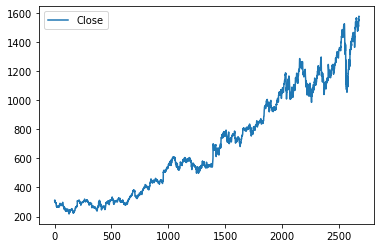

In [9]:
fig = plt.figure()

plt.plot(historical_data.Close)

plt.legend(["Close", "Open"])

# Feature Engineering

In [10]:
historical_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2009-12-31,312.69,313.01,310.30,310.30,2437100,0,0.0
1,2010-01-04,313.79,315.07,312.43,313.69,3908400,0,0.0
2,2010-01-05,313.90,314.23,311.08,312.31,6003300,0,0.0
3,2010-01-06,313.24,313.24,303.48,304.43,7949400,0,0.0
4,2010-01-07,305.01,305.31,296.62,297.35,12815700,0,0.0


In [11]:
historical_data.drop(
    columns=["Dividends", "Stock Splits", "Volume"], inplace=True)

In [12]:
# Add placeholder for forecast
present_date = historical_data.Date.max()
day_number = pd.to_datetime(present_date).isoweekday()

if day_number in [5, 6]:
    next_date = present_date + datetime.timedelta(days=(7-day_number) + 1)
else:
    next_date = present_date + datetime.timedelta(days=1)
print("Present date:", present_date)
print("Next valid date:", next_date)

test_row = pd.DataFrame([[next_date, 0.0, 0.0, 0.0, 0.0]], columns=historical_data.columns)
test_row.head()

Present date: 2020-08-21 00:00:00
Next valid date: 2020-08-24 00:00:00


,Date,Open,High,Low,Close
0,2020-08-24,0.0,0.0,0.0,0.0


In [13]:
historical_data = pd.concat([historical_data, test_row])

In [14]:
# Create lag features
for i in range(1, 7):
    historical_data[f"Close_lag_{i}"] = historical_data.Close.shift(periods=i, axis=0)
    historical_data[f"Open_lag_{i}"] = historical_data.Open.shift(periods=i, axis=0)
    historical_data[f"High_lag_{i}"] = historical_data.High.shift(periods=i, axis=0)
    historical_data[f"Low_lag_{i}"] = historical_data.Low.shift(periods=i, axis=0)

historical_data.head()

,Date,Open,High,Low,Close,Close_lag_1,Open_lag_1,High_lag_1,Low_lag_1,Close_lag_2,...,High_lag_4,Low_lag_4,Close_lag_5,Open_lag_5,High_lag_5,Low_lag_5,Close_lag_6,Open_lag_6,High_lag_6,Low_lag_6
0,2009-12-31,312.69,313.01,310.30,310.30,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-04,313.79,315.07,312.43,313.69,310.30,312.69,313.01,310.30,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-05,313.90,314.23,311.08,312.31,313.69,313.79,315.07,312.43,310.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-06,313.24,313.24,303.48,304.43,312.31,313.90,314.23,311.08,313.69,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-07,305.01,305.31,296.62,297.35,304.43,313.24,313.24,303.48,312.31,...,313.01,310.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
historical_data.fillna(0, inplace=True)
historical_data.head()

,Date,Open,High,Low,Close,Close_lag_1,Open_lag_1,High_lag_1,Low_lag_1,Close_lag_2,...,High_lag_4,Low_lag_4,Close_lag_5,Open_lag_5,High_lag_5,Low_lag_5,Close_lag_6,Open_lag_6,High_lag_6,Low_lag_6
0,2009-12-31,312.69,313.01,310.30,310.30,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-01-04,313.79,315.07,312.43,313.69,310.30,312.69,313.01,310.30,0.00,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-01-05,313.90,314.23,311.08,312.31,313.69,313.79,315.07,312.43,310.30,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-01-06,313.24,313.24,303.48,304.43,312.31,313.90,314.23,311.08,313.69,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-01-07,305.01,305.31,296.62,297.35,304.43,313.24,313.24,303.48,312.31,...,313.01,310.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
historical_data.drop(
    columns=["Open", "High", "Low"], inplace=True)

In [17]:
# # Create a holiday dataframe
# min_date, max_date = historical_data.Date.min(), historical_data.Date.max()
# print("Min/Max dates:", min_date, max_date)

# date_range = pd.date_range(start=min_date, end=max_date)
# print("Date range:", date_range.min(), date_range.max())

# # Find dates not present in historical df - closed stock market holiday
# holiday_date_range = [d.date() for d in date_range if d not in historical_data.Date]
# holiday_date_range[:5]

In [18]:
# holidays = pd.DataFrame({
#     "holiday": "shutdown",
#     "ds": pd.to_datetime(holiday_date_range),
#     "lower_bound": 0,
#     "upper_bound": 1,
# })

# holidays.head()

# Modelling

## Facebook's Prophet: Single Timestep Forecasting

References: 
+ https://facebook.github.io/prophet/

In [19]:
import s as prophet

### Train and Forecast

In [20]:
lag_features = [col for col in historical_data.columns if "lag" in col]

In [21]:
model = prophet.Prophet(yearly_seasonality=True, weekly_seasonality=True, seasonality_mode="additive")
for name in lag_features:
    model.add_regressor(name)

model.fit(df=historical_data.iloc[:-1, :].rename(columns={"Date": "ds", "Close":"y"}))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [22]:
forecast = model.predict(
    historical_data.iloc[-1:][[col for col in historical_data.columns if col != "Close"]].rename(columns={"Date": "ds"})
)

forecast.shape

(1, 94)

In [23]:
forecast.yhat

0    1564.282633
Name: yhat, dtype: float64